In [2]:
from tqdm.notebook import tqdm
import torch
import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from models import unet
import torchvision

In [3]:
train_transforms = A.Compose(
        [
            A.Resize(height=256, width=256),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


In [4]:
train_dataset = datasets.tdsc.TDSC(path_to_dataset="./data/tdsc/train", transform=train_transforms)
validation_dataset = datasets.tdsc.TDSC(path_to_dataset="./data/tdsc/validation", transform=val_transforms)

## Building the model

In [5]:
model = unet.UNet(in_channels=1, out_channels=1)

## Dice loss

In [6]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        intersection = (predictions * targets).sum()
        dice_coefficient = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        # The Dice Loss is the complement of the Dice Coefficient
        dice_loss = 1 - dice_coefficient

        return dice_loss

## Training hyperparameters

In [7]:
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 20
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device=device)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def train(model, dataset, optimizer, loss_fn, brighter=0):

    model.train()
    loop = tqdm(dataset)

    for idx, data in enumerate(loop):
        vol, mask, y = data
        for i in range(vol.shape[1]):
            x = vol[:,i,:,:]
            m = mask[:,i,:,:]
            if brighter != 0:
                x = x + m*brighter
            x = x.unsqueeze(0)
            m = m.unsqueeze(0)
            x = x.to(device)
            m = m.to(device)
            # forward
            with torch.cuda.amp.autocast():
                predictions = torch.sigmoid(model(x))
                loss = loss_fn(predictions, m)

            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [9]:
def calculate_accuracy(dataset, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    model.eval()

    with torch.no_grad():
        for vol, mask, l in dataset:
            for i in range(vol.shape[1]):
                x = vol[:,i,:,:]
                y = mask[:,i,:,:]
                x = x.unsqueeze(0)
                y = y.unsqueeze(0)
                x = x.to(device)
                y = y.to(device).unsqueeze(1)
                preds = torch.sigmoid(model(x))
                preds = (preds > 0.5).float()
                num_correct += (preds == y).sum()
                num_pixels += torch.numel(preds)
                dice_score += (2 * (preds * y).sum()) / (
                    (preds + y).sum() + 1e-8
                )

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(dataset)}")
    
    model.train()


In [16]:
x,m,y = train_dataset[10]
x = x.squeeze(0)
m = m.squeeze(0)
print(x.shape, m.shape)

torch.Size([37, 256, 256]) torch.Size([37, 256, 256])


In [ ]:
sx = x[10,:,:]
sm = y[10,:,:]

print(sx.shape, sm.shape)

In [10]:
def save_results_as_imgs(model, dataset, path="./saved_images"):
    model.eval()
    idx = np.random.randint(0,20)
    vol, mask, label = dataset[idx]
    with torch.no_grad():
        for i in range(vol.shape[1]):
            x = vol[:,i,:,:]
            y = mask[:,i,:,:]
            x = x.unsqueeze(0)
            y = y.unsqueeze(0)
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            y = y.squeeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            torchvision.utils.save_image(preds, f"{path}/pred_{i}.png")
            torchvision.utils.save_image(y.squeeze(1), f"{path}/{i}.png")
    
    model.train()

In [11]:
for i in range(num_epochs):
    train(model, train_dataset, optimizer, criterion)
    calculate_accuracy(validation_dataset, model)
    save_results_as_imgs(model, validation_dataset)


  0%|          | 0/79 [00:00<?, ?it/s]

/home/ozma/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

Got 38786331/39780352 with acc 97.50
Dice score: 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

torch.Size([1, 1, 256, 256])
(256, 256) (256, 256)


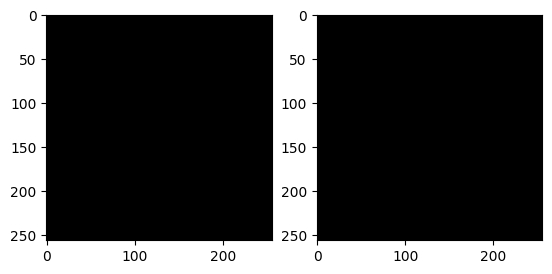

In [11]:
model.eval()

x, m, y = validation_dataset[10]
prediction = torch.sigmoid(model(x[:,14:15,:,:].to(device)))
prediction = (prediction > 0.5).float()
print (prediction.shape)
pred = prediction.squeeze()
m = m[:,14:15,:,:]
m = m.squeeze()
pred = pred.to('cpu').detach().numpy()
m = m.to('cpu').detach().numpy()
print (m.shape, pred.shape)

plt.subplot(1,2,1)
plt.imshow(pred)
plt.subplot(1,2,2)
plt.imshow(m)
plt.show()